In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pyrosetta
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
from math import pi
from tqdm import tqdm

pyrosetta.init('-mute all')

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python312.Release 2024.17+release.baad48240e60f121d84dc6443bd8745c8d8becdc 2024-04-24T11:34:17] retrieved from: http://www.pyrosetta.org


## Prolog

The following notebook contains the functions for filtering the pdbs and calculating amino acid frequencies for the extracted proteins and also the finally designed proteins. Obviously, the pdbs are not contained in this directory due to their size. They were organised as follows:
```
├── af_models
│   ├── download_alphafold_structures.sh     # <- script to download all structures
│   ├── ecoli_alphaFold_models               # Raw AF2 predictions of all e.coli proteins
│   ├── filter_pLDDT.py                      # <- script to filter AF2 predicitons based on pLDDT
│   └── hyperthermo_alphaFold_models         # Raw AF2 predicitons of all hyperthermophilic proteins used
├── af_models_design
│   ├── ecoli_hyper                          # Designs of filtered e.coli proteins using HyperMPNN
│   ├── ecoli_mpnn                           # Designs of filtered e.coli proteins using default ProteinMPNN
│   ├── thermo_hyper                         # Designs of filtered hyperthermophilic proteins using HyperMPNN
│   └── thermo_mpnn                          # Designs of filtered hyperthermophilic proteins using default ProteinMPNN
├── af_models_filtered
│   ├── ecoli_filtered_plddt                 # Filtered AF2 predictions of e.coli
│   └── hyperthermo_filtered_plddt           # Filtered AF2 predicition of hyperthermophilic proteins
```

They would have to be recreated. However, the results of the calculations are stored in the `data` folder.



## 1. Function for processing pdbfiles
The following functions are used to process pdb files from all collected *E. coli* and hyperthermophilic proteins. The proteins were downloaded using their corresponding the UniProt IDs using the provided script `download_alphafold_structures.sh` in `af_models`. Processing involves filtering proteins for low pLDDT values and remove low start and end stretches with low prediction to truncate the structures. The filter step can also be performed using the python script `af_models/filter_pLDDT.py` instead of the jupyter cell here in section 1.

### Filter pdbs

In [4]:
def remove_low_pLDDT_stretches(pose: pyrosetta.Pose, 
                               per_res_pLDDT: list[float], 
                               low_pLDDT_threshold: float) -> tuple[pyrosetta.Pose, bool]:
    
    start, end = 1, len(per_res_pLDDT)
    modified = False

    # Calculate length of start and end stretches
    start_stretch_length = sum(1 for plddt in per_res_pLDDT if plddt < low_pLDDT_threshold)
    end_stretch_length = sum(1 for plddt in reversed(per_res_pLDDT) if plddt < low_pLDDT_threshold)

    # Skip deletion if stretches are more than half of the pose
    if start_stretch_length + end_stretch_length > len(per_res_pLDDT) / 2:
        return pose, False

    # Identifying and removing start stretch
    while start <= len(per_res_pLDDT) and per_res_pLDDT[start - 1] < low_pLDDT_threshold:
        start += 1
    if start - 1 >= 10:
        pose.delete_residue_range_slow(1, start - 1)
        modified = True
        # Adjust per_res_pLDDT list after removing start stretch
        per_res_pLDDT = per_res_pLDDT[start - 1:]

    # Recalculate the end index based on the updated per_res_pLDDT list
    end = len(per_res_pLDDT)

    # Identifying and removing end stretch
    while end > 0 and per_res_pLDDT[end - 1] < low_pLDDT_threshold:
        end -= 1
    if len(per_res_pLDDT) - end >= 10:
        pose.delete_residue_range_slow(end + 1, len(per_res_pLDDT))
        modified = True

    return pose, modified

# --------------------------------------------------------------------------------------------

def process_pdb_file(pdb_file: str, output_dir: str, pLDDT_threshold: float = 70) -> str:

    pose = pyrosetta.pose_from_pdb(pdb_file)
    num_residues = pose.total_residue()

    per_res_pLDDT = [pose.pdb_info().bfactor(i, 1) for i in range(1, num_residues + 1) if pose.residue(i).is_protein()]
    modified_pose, modified = remove_low_pLDDT_stretches(pose, per_res_pLDDT, pLDDT_threshold)
    
    total_pLDDT = sum([modified_pose.pdb_info().bfactor(i, 1) for i in range(1, modified_pose.total_residue() + 1)])
    new_average_pLDDT = total_pLDDT / modified_pose.total_residue() if modified_pose.total_residue() > 0 else 0
    
    if new_average_pLDDT >= pLDDT_threshold:
        pyrosetta.dump_pdb(modified_pose, os.path.join(output_dir, os.path.basename(pdb_file)))
        return pdb_file
    else:
        return None

# --------------------------------------------------------------------------------------------

def filter_based_on_pLDDT(pdb_files: list[str], output_dir: str, pLDDT_threshold: float = 70) -> list[str]:
    filtered_pdb_files = []

    # Function to process each file, adjusted for ProcessPoolExecutor
    def process_file(pdb_file):
        return process_pdb_file(pdb_file, output_dir, pLDDT_threshold)

    # Using ProcessPoolExecutor for multiprocessing
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Creating a progress bar with tqdm
        results = list(tqdm(executor.map(process_file, pdb_files), total=len(pdb_files)))

    filtered_pdb_files = [result for result in results if result is not None]
    return filtered_pdb_files

In [ ]:
# Was running only once at the beginning -> therefore commented out
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Filter all pdbs in the directory based on pLDDT
# E. coli protein predictions
# ecoli_raw_path = '../af_models/ecoli_alphaFold_models/'
# ecoli_filtered_out_path = '../af_models_filtered/ecoli_filtered_plddt/'
# ecoli_pdbs = [os.path.join(ecoli_raw_path, file) for file in os.listdir(ecoli_raw_path)]
# ecoli_filtered_pdbs = filter_based_on_pLDDT(ecoli_pdbs, ecoli_filtered_out_path, pLDDT_threshold=70)

# Hyperthermophilic protein predictions
# thermo_raw_path = '../af_models/hyperthermo_alphaFold_models/'
# thermo_filtered_out_path = '../af_models_filtered/hyperthermo_filtered_plddt/'
# thermo_pdbs = [os.path.join(thermo_raw_path, file) for file in os.listdir(thermo_raw_path)]
# hyper_filtered_pdbs = filter_based_on_pLDDT(thermo_pdbs, thermo_filtered_out_path, pLDDT_threshold=70)

## 2. Calculate frequencies

Based on the filtered pdbs we wanna calculate the calculate the amino acid core and surface fractions for *E. coli* and hyperthermophilic proteins and classify them into groups like positively charged, negativly charged, polar, and apolar. After the full calculation of everything above we can visualize the results. We will plot the core and surface amino acid based on groups, eg. pos. charged/neg. charged.

In [4]:
def process_pdb_file_for_classify(pdb_file: str) -> dict:

    aa_freq = {'surface': {}, 'core': {}}

    pose = pyrosetta.pose_from_file(pdb_file)
    prsm = pyrosetta.rosetta.core.simple_metrics.per_residue_metrics.PerResidueSasaMetric()
    sasa = prsm.calculate(pose)

    for i in range(1, pose.total_residue() + 1):
        residue = pose.residue(i)
        if not residue.is_protein():
            continue
        
        aa = residue.name1()
        sasa_value = sasa[i]
    
        if sasa_value > 30:
            region = 'surface'
        else:
            region = 'core'
    
        if aa in aa_freq[region]:
            aa_freq[region][aa] += 1
        else:
            aa_freq[region][aa] = 1
    
    return aa_freq

# --------------------------------------------------------------------------------------------

def classify_residues(pdb_files: list[str]) -> dict:
    aggregated_aa_freq = {'surface': {}, 'core': {}}

    def update_progress_bar(future):
        progress.update(1)

    with ProcessPoolExecutor(max_workers=5) as executor:
        # Create a tqdm progress bar
        progress = tqdm(total=len(pdb_files), desc="Processing PDB files")

        # Submit tasks and attach a callback to update the progress bar
        futures = [executor.submit(process_pdb_file_for_classify, pdb_file) for pdb_file in pdb_files]
        for future in futures:
            future.add_done_callback(update_progress_bar)

        for future in futures:
            aa_freq = future.result()
            for region in ['surface', 'core']:
                for aa, count in aa_freq[region].items():
                    if aa in aggregated_aa_freq[region]:
                        aggregated_aa_freq[region][aa] += count
                    else:
                        aggregated_aa_freq[region][aa] = count

    return aggregated_aa_freq

# --------------------------------------------------------------------------------------------
def normalize_and_classify(aa_freq):
    # Normalize frequencies
    total_counts = sum(aa_freq.values())
    normalized_freq = {aa: count / total_counts for aa, count in aa_freq.items()}

    # Classify and aggregate
    classified_freq = {key: 0 for key in classifications.keys()}
    for aa, count in normalized_freq.items():
        for class_name, aas in classifications.items():
            if aa in aas:
                classified_freq[class_name] += count
                break

    return classified_freq

# Classification of amino acids
classifications = {
    'positively charged': ['R', 'K'],
    'negatively charged': ['D', 'E'],
    'polar': ['N', 'Q', 'S', 'T'],
    'apolar': ['I', 'L', 'M', 'F', 'W', 'Y', 'V'],
    'others': ['A', 'C', 'G', 'H', 'P']
}

In [ ]:
# Was calculated only once at the beginning -> therefore commented out
# results were saved in pickle files
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# # E. coli filtered pdbs
# filtered_pdbs_ecoli_path = '../af_models_filtered/ecoli_filtered_plddt/'
# filtered_pdbs_ecoli = [os.path.join(filtered_pdbs_ecoli_path, file) for file in os.listdir(filtered_pdbs_ecoli_path)]
# aa_freq_ecoli = classify_residues(filtered_pdbs_ecoli)
# with open('data/aa_freq_ecoli.pkl', 'wb') as file:
#     pickle.dump(aa_freq_ecoli, file)

# # Hyperthermophilic filtered pdbs
# filtered_pdbs_thermo_path = '../af_models_filtered/hyperthermo_filtered_plddt/'
# filtered_pdbs_thermo = [os.path.join(filtered_pdbs_thermo_path, file) for file in os.listdir(filtered_pdbs_thermo_path)]
# aa_freq_thermo = classify_residues(filtered_pdbs_thermo)
# with open('data/aa_freq_thermo.pkl', 'wb') as file:
#     pickle.dump(aa_freq_thermo, file)

### Visualizing E. coli

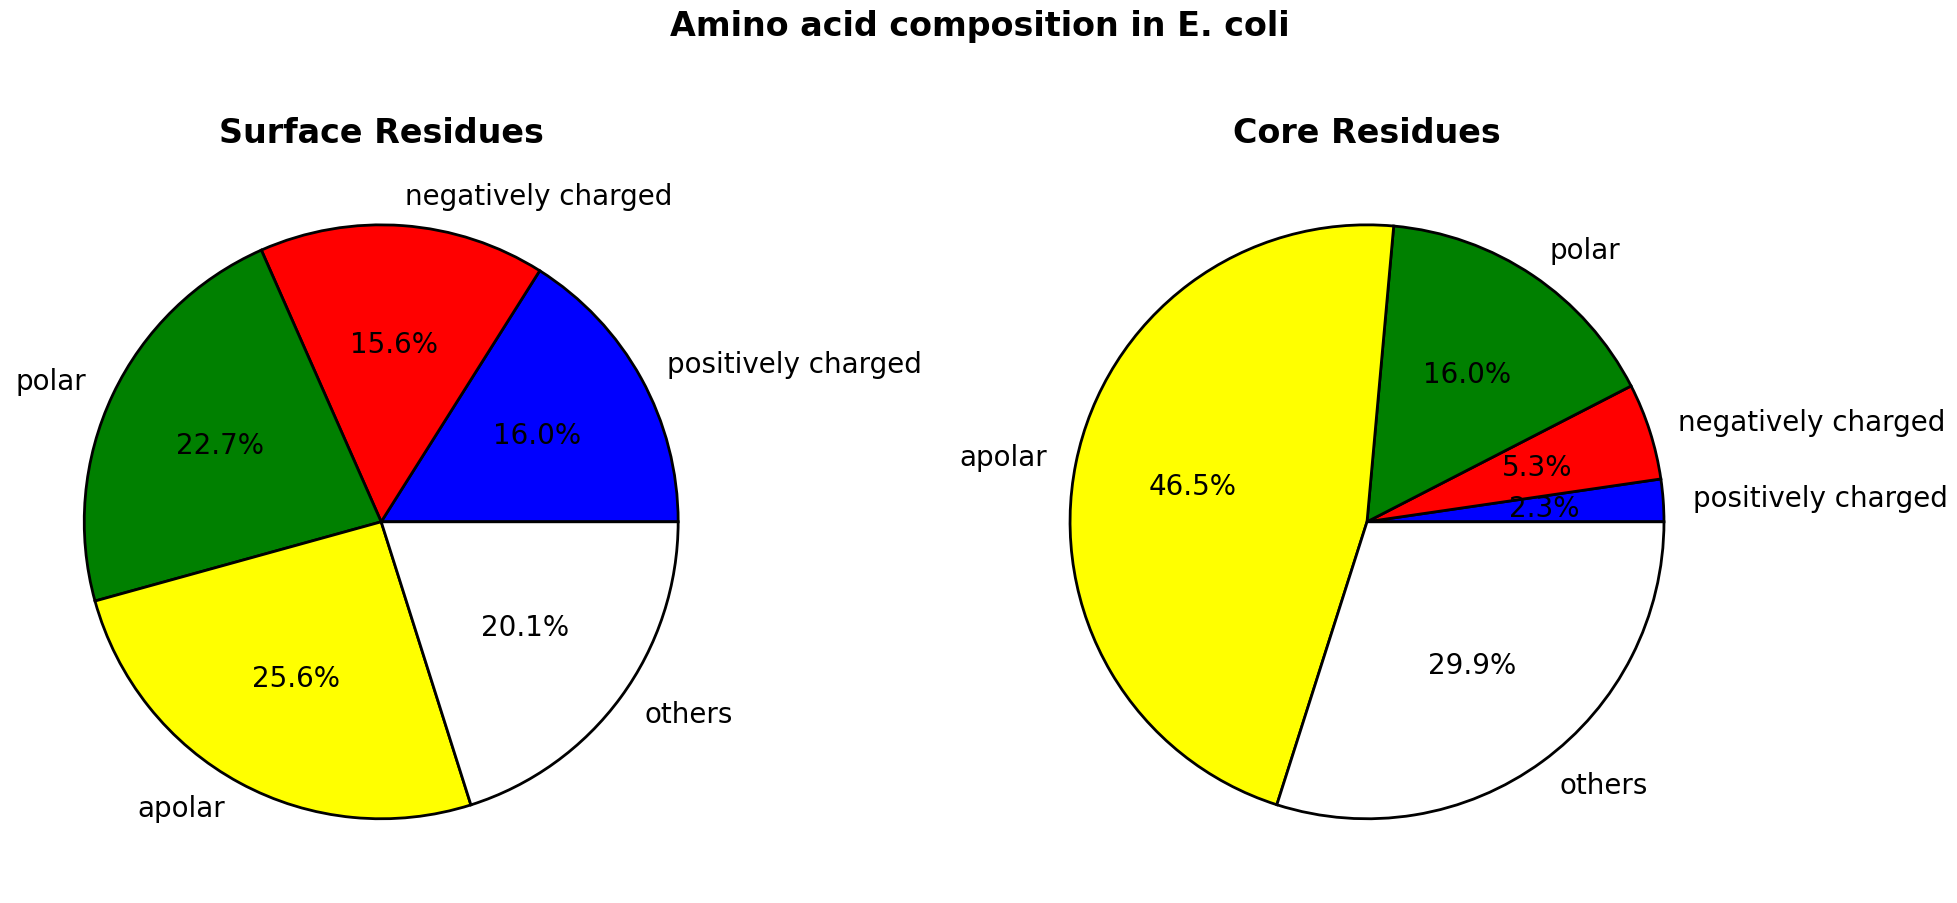

In [43]:
# Define the color scheme
colors = {
    'positively charged': 'blue',
    'negatively charged': 'red',
    'polar': 'green',
    'apolar': 'yellow',
    'others': 'white'
}

aa_freq_ecoli = './data/aa_freq_ecoli.pkl'
with open(aa_freq_ecoli, 'rb') as file:
    aa_freq_ecoli = pickle.load(file)

normalized_surface = normalize_and_classify(aa_freq_ecoli['surface'])
normalized_core = normalize_and_classify(aa_freq_ecoli['core'])

plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')
axes[0].pie(normalized_surface.values(), labels=normalized_surface.keys(), autopct='%1.1f%%', \
    colors=[colors[key] for key in normalized_surface.keys()], wedgeprops={"edgecolor":"k",'linewidth': 2})
axes[0].set_title('Surface Residues', weight='bold')

axes[1].pie(normalized_core.values(), labels=normalized_core.keys(), autopct='%1.1f%%', \
    colors=[colors[key] for key in normalized_surface.keys()], wedgeprops={"edgecolor":"k",'linewidth': 2})
axes[1].set_title('Core Residues', weight='bold')

plt.suptitle('Amino acid composition in E. coli', fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('pic/aa_groups_composition_ecoli.svg', dpi=400)
plt.show()

### Visualising Hyperthermophiles

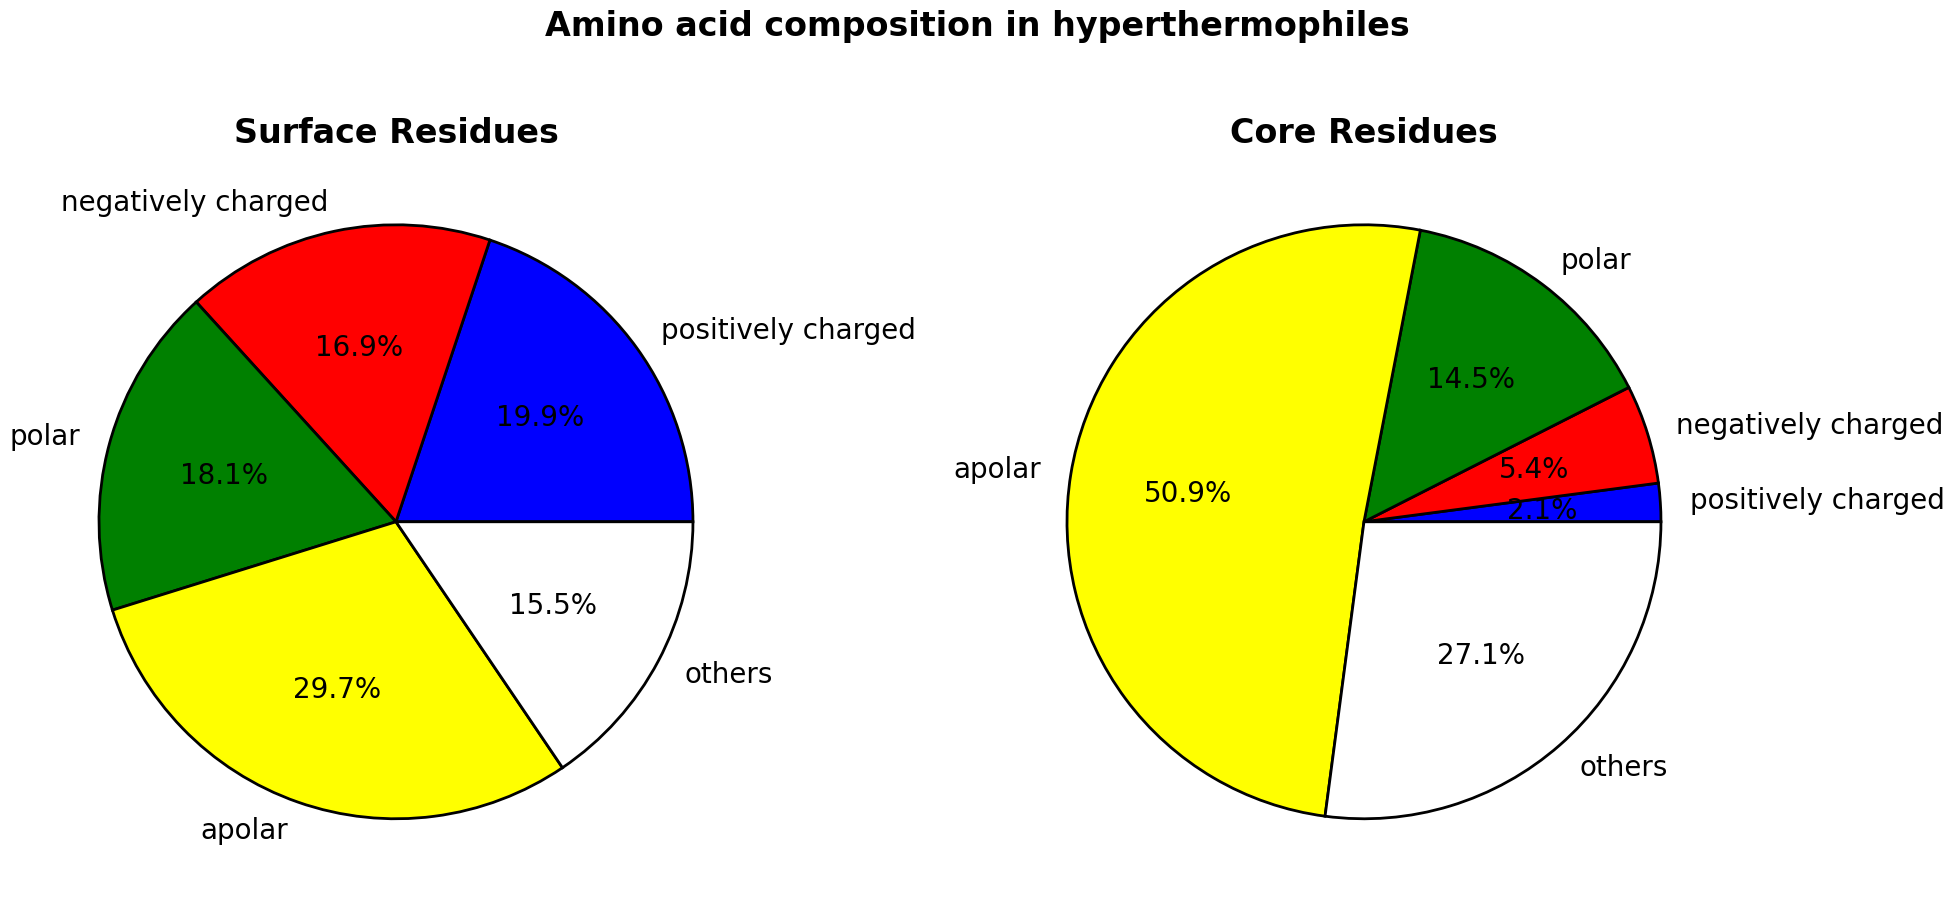

In [44]:
# Define the color scheme
colors = {
    'positively charged': 'blue',
    'negatively charged': 'red',
    'polar': 'green',
    'apolar': 'yellow',
    'others': 'white'
}

aa_freq_thermo = './data/aa_freq_thermo.pkl'
with open(aa_freq_thermo, 'rb') as file:
    aa_freq_thermo = pickle.load(file)

normalized_surface = normalize_and_classify(aa_freq_thermo['surface'])
normalized_core = normalize_and_classify(aa_freq_thermo['core'])

plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')
axes[0].pie(normalized_surface.values(), labels=normalized_surface.keys(), autopct='%1.1f%%', \
    colors=[colors[key] for key in normalized_surface.keys()], wedgeprops={"edgecolor":"k",'linewidth': 2})
axes[0].set_title('Surface Residues', weight='bold')

axes[1].pie(normalized_core.values(), labels=normalized_core.keys(), autopct='%1.1f%%', \
    colors=[colors[key] for key in normalized_surface.keys()], wedgeprops={"edgecolor":"k",'linewidth': 2})
axes[1].set_title('Core Residues', weight='bold')

plt.suptitle('Amino acid composition in hyperthermophiles', fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('pic/aa_groups_composition_thermo.svg', dpi=400)

## 3. Frequencies of design

We also want to calculate the frequencies for the individual amino acids, based in the surface and core classification for the design using both networks. In the paper we also plotted the frequencies after the design, therefore there are also included in the following plot. The design was performed for every *E. coli* structure and every hyperthermophilic structure, using the original ProteinMPNN and the fine tuned HyperMPNN.

From the paper:
*ProteinMPNN and HyperMPNN designs of proteins from E. coli or hyperthermophiles were created by sampling one sequence per protein at temperature of 0.001. The resulting sequences were threaded on the input structures using the Rosetta SimpleThreadingMover with five rounds of packing.*

**That means the following pictures are generated after HyperMPNN was already retrained.**

The following `pkl` files were calculated and saved based on the functions shown in section 2. of this notebook.

### Design hyperthermophiles proteins

In [6]:
import seaborn as sns

In [14]:
import pickle
def create_pickle(f):
    with open(f, 'rb') as file:
        aa_freq = pickle.load(file)
    return aa_freq
# Load 
aa_freq_ecoli = create_pickle('./data/aa_freq_ecoli.pkl')
aa_freq_thermo = create_pickle('./data/aa_freq_thermo.pkl')

aa_freq_thermo_mpnn  = create_pickle('./data/aa_freq_mpnn_thermo_with_python_MPNN.pkl')
aa_freq_thermo_hyper = create_pickle('./data/aa_freq_mpnn_tuned_thermo_with_python_MPNN.pkl')

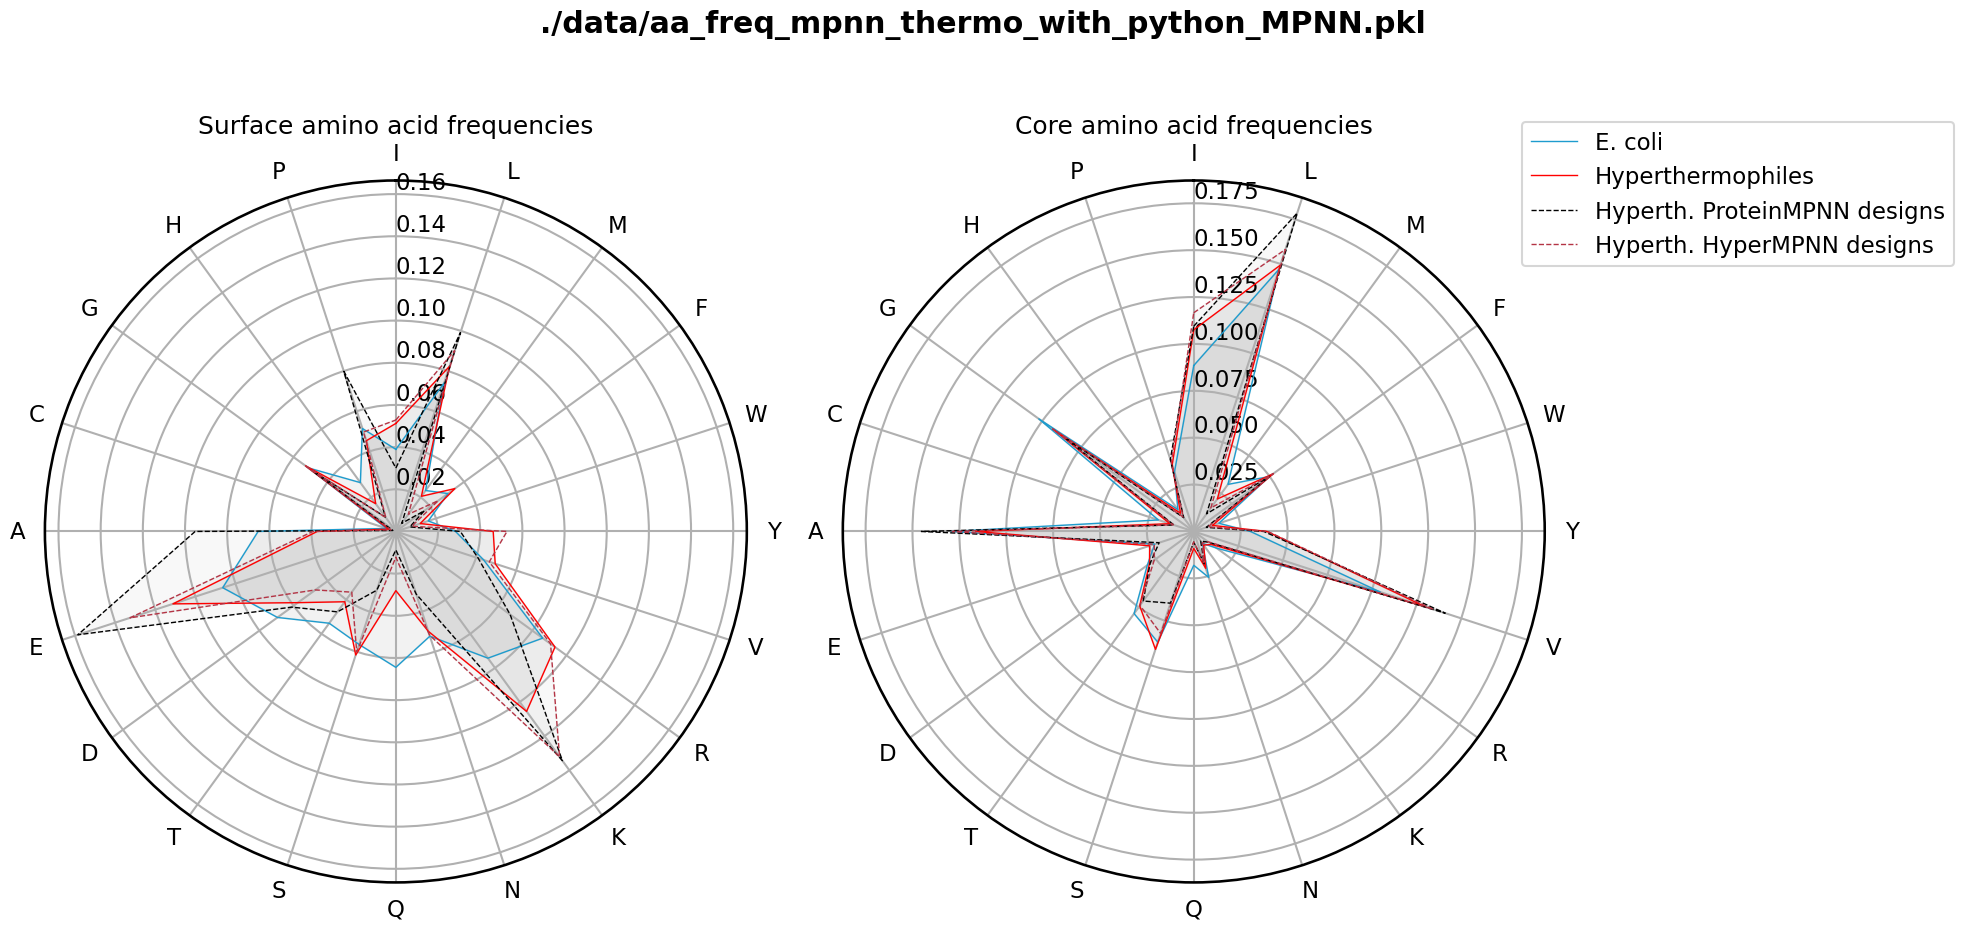

In [15]:
sns.set_context('talk')
# Normalize the frequencies for each category
def normalize_freq(freq):
    total = sum(freq.values())
    return {aa: val / total for aa, val in freq.items()}


aa_freq_ecoli_normalized = {key: normalize_freq(aa_freq_ecoli[key]) for key in aa_freq_ecoli}
aa_freq_mpnn_thermo_normalized = {key: normalize_freq(aa_freq_thermo_mpnn[key]) for key in aa_freq_thermo_mpnn}
aa_freq_thermo_normalized = {key: normalize_freq(aa_freq_thermo[key]) for key in aa_freq_thermo}
aa_freq_mpnn_tuned_thermo_normalized = {key: normalize_freq(aa_freq_thermo_hyper[key]) for key in aa_freq_thermo_hyper}


amino_acids_ordered = classifications['apolar']+ classifications['positively charged'] + classifications['polar'] + classifications['negatively charged'] + classifications['others'] 
# Number of variables (amino acids)
num_vars = len(amino_acids_ordered )

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the spider plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(polar=True), facecolor='white')

# Function to plot each radar chart
def plot_radar_chart(ax, freq_ecoli, freq_thermo, freq_mpnn_thermo, freq_mpnn_tuned_thermo, title):
    # Data
  # Get values in the new order
    values_ecoli = [freq_ecoli[aa] for aa in amino_acids_ordered] + [freq_ecoli[amino_acids_ordered[0]]]
    values_thermo_mpnn = [freq_mpnn_thermo[aa] for aa in amino_acids_ordered] + [freq_mpnn_thermo[amino_acids_ordered[0]]]
    values_thermo = [freq_thermo[aa] for aa in amino_acids_ordered] + [freq_thermo[amino_acids_ordered[0]]]
    values_thermo_mpnn_tuned = [freq_mpnn_tuned_thermo[aa] for aa in amino_acids_ordered] + [freq_mpnn_tuned_thermo[amino_acids_ordered[0]]]


    # Plot
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1], amino_acids_ordered)
    ax.set_rlabel_position(0)
    #plt.yticks(color="grey", size=7)
    #ax.tick_params(axis='y',color="grey", size=7)
    ax.plot(angles, values_ecoli, linewidth=1, linestyle='solid', label='E. coli', color='#1E9CCE')
    ax.fill(angles, values_ecoli, alpha=0.1, color='grey')
    ax.plot(angles, values_thermo, linewidth=1, linestyle='solid', label='Hyperthermophiles', color='#FF0000')
    ax.fill(angles, values_thermo, alpha=0.1, color='grey')
    ax.plot(angles, values_thermo_mpnn, linewidth=1, linestyle='dashed', label='Hyperth. ProteinMPNN designs', color='k')
    ax.fill(angles, values_thermo_mpnn, alpha=0.05, color='grey')
    ax.plot(angles, values_thermo_mpnn_tuned, linewidth=1, linestyle='dashed', label='Hyperth. HyperMPNN designs', color='#B43445')
    ax.fill(angles, values_thermo_mpnn_tuned, alpha=0.05, color='grey')
    ax.set_title(title)
    #ax.legend(loc='upper right')


# Plot surface and core radar charts
plot_radar_chart(ax1, aa_freq_ecoli_normalized['surface'], aa_freq_thermo_normalized['surface'], aa_freq_mpnn_thermo_normalized['surface'], aa_freq_mpnn_tuned_thermo_normalized['surface'], 'Surface amino acid frequencies')
plot_radar_chart(ax2, aa_freq_ecoli_normalized['core'], aa_freq_thermo_normalized['core'], aa_freq_mpnn_thermo_normalized['core'], aa_freq_mpnn_tuned_thermo_normalized['core'], 'Core amino acid frequencies')
plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1.1))
plt.suptitle('./data/aa_freq_mpnn_thermo_with_python_MPNN.pkl', weight='bold')

plt.tight_layout()
plt.savefig('./radar_plot_thermo_design_data_aa_freq_mpnn_thermo_with_python_MPNN.png', dpi=400, bbox_inches='tight')

### Design E. coli proteins

In [27]:
def create_pickle(f):
    with open(f, 'rb') as file:
        aa_freq = pickle.load(file)
    return aa_freq
# Load 
aa_freq_ecoli = create_pickle('./data/aa_freq_ecoli.pkl')
aa_freq_thermo = create_pickle('./data/aa_freq_thermo.pkl')

aa_freq_ecoli_mpnn  = create_pickle('./data/aa_freq_mpnn_ecoli.pkl')
aa_freq_ecoli_hyper = create_pickle('./data/aa_freq_mpnn_tuned_ecoli.pkl')

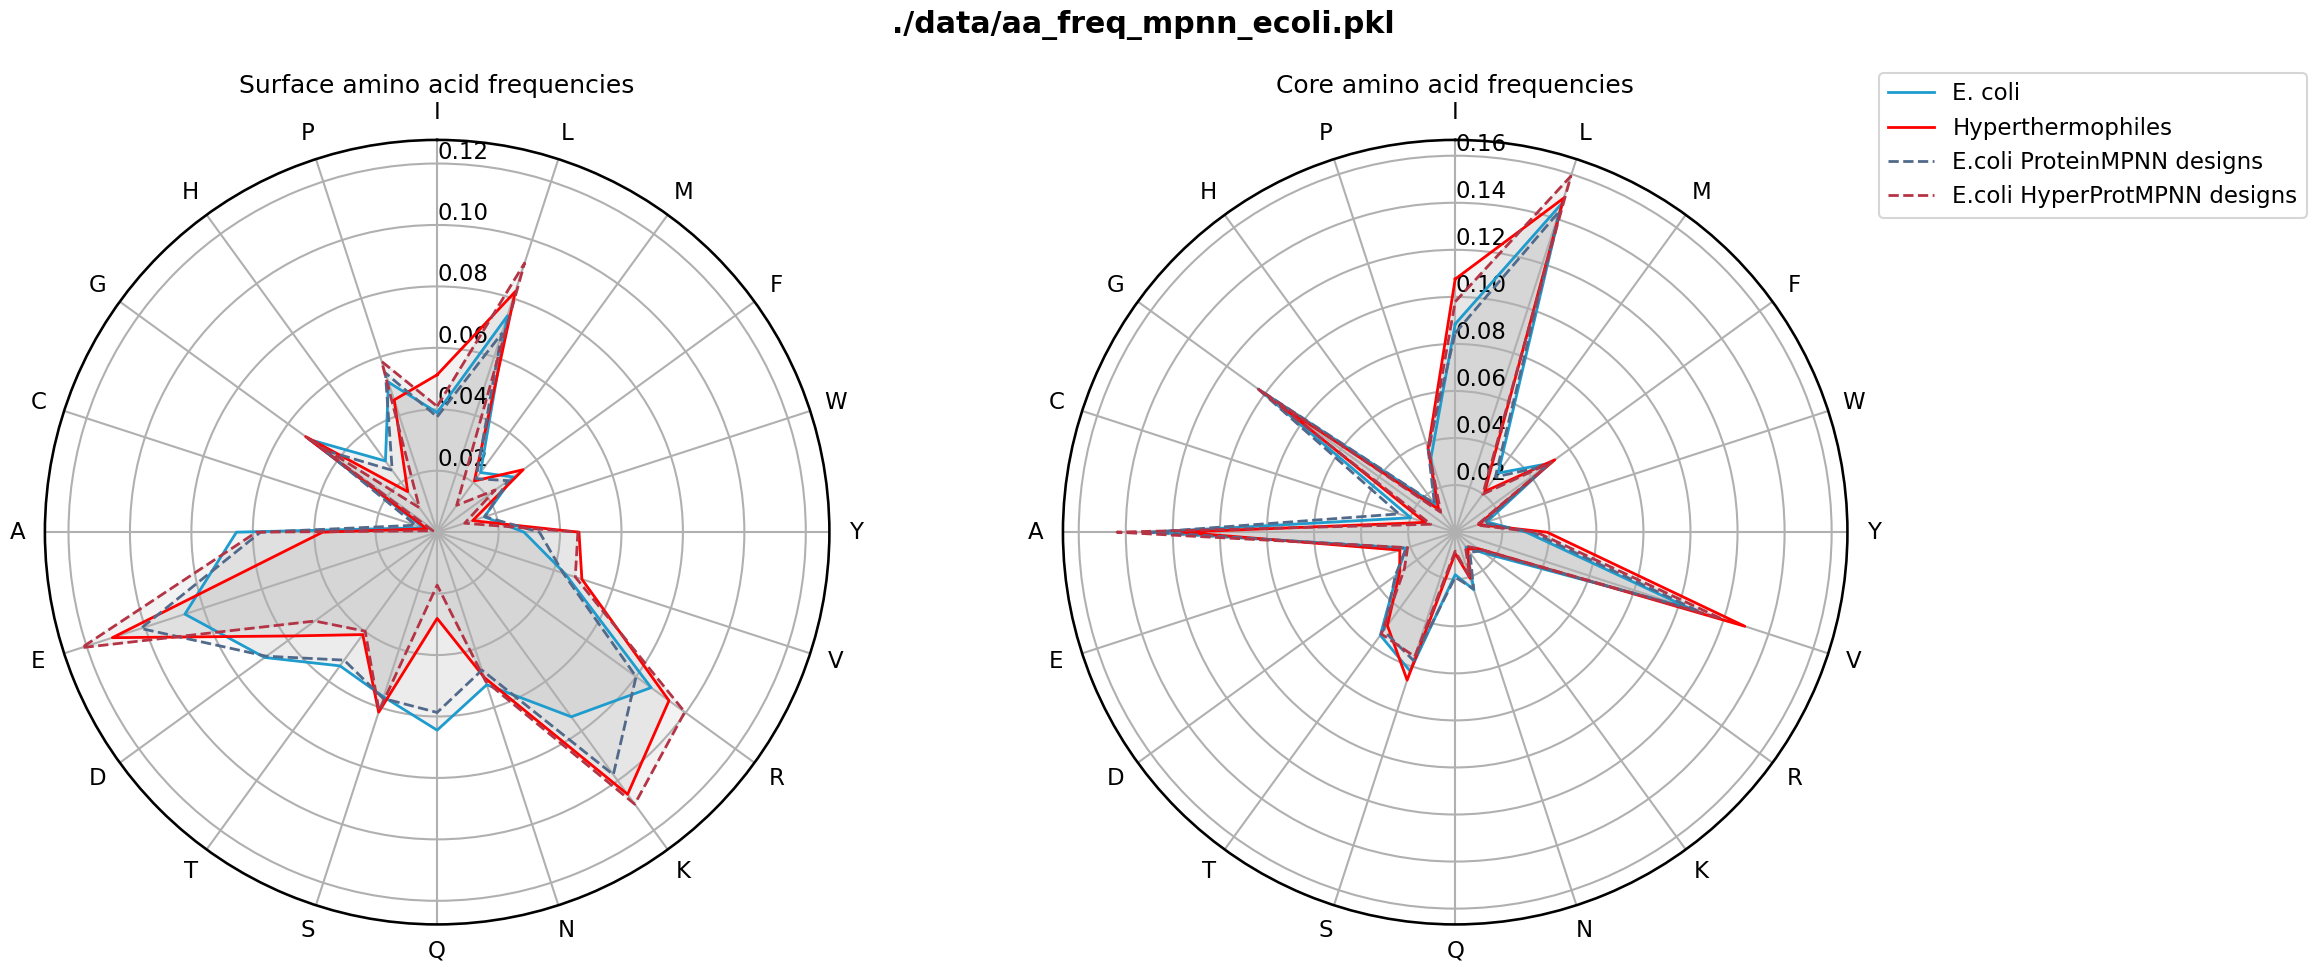

In [28]:
colors = ['#1E9CCE','#FF0000','#51698A','#B43445']
# Normalize the frequencies for each category
def normalize_freq(freq):
    total = sum(freq.values())
    return {aa: val / total for aa, val in freq.items()}


aa_freq_ecoli_normalized = {key: normalize_freq(aa_freq_ecoli[key]) for key in aa_freq_ecoli}
aa_freq_ecoli_mpnn_normalized = {key: normalize_freq(aa_freq_ecoli_mpnn[key]) for key in aa_freq_ecoli_mpnn}
aa_freq_ecoli_mpnn_tuned_normalized = {key: normalize_freq(aa_freq_ecoli_hyper[key]) for key in aa_freq_ecoli_hyper}
aa_freq_thermo_normalized = {key: normalize_freq(aa_freq_thermo[key]) for key in aa_freq_thermo}


amino_acids_ordered = classifications['apolar']+ classifications['positively charged'] + classifications['polar'] + classifications['negatively charged'] + classifications['others'] 
# Number of variables (amino acids)
num_vars = len(amino_acids_ordered )

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the spider plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), subplot_kw=dict(polar=True), facecolor='white')



# Function to plot each radar chart
def plot_radar_chart(ax, freq_ecoli, freq_tuned_mpnn_ecoli, freq_mpnn_ecoli, freq_thermo,title):
    # Data
  # Get values in the new order
    values_ecoli = [freq_ecoli[aa] for aa in amino_acids_ordered] + [freq_ecoli[amino_acids_ordered[0]]]
    values_ecoli_mpnn = [freq_mpnn_ecoli[aa] for aa in amino_acids_ordered] + [freq_mpnn_ecoli[amino_acids_ordered[0]]]
    values_ecoli_mpnn_tuned = [freq_tuned_mpnn_ecoli[aa] for aa in amino_acids_ordered] + [freq_tuned_mpnn_ecoli[amino_acids_ordered[0]]]
    values_thermo = [freq_thermo[aa] for aa in amino_acids_ordered] + [freq_thermo[amino_acids_ordered[0]]]


    # Plot
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1], amino_acids_ordered)
    ax.set_rlabel_position(0)
    #plt.yticks(color="grey", size=7)
    #ax.tick_params(axis='y',color="grey", size=7)

    
    ax.plot(angles, values_ecoli, linewidth=2, linestyle='solid', label='E. coli', color='#1E9CCE')
    ax.fill(angles, values_ecoli, alpha=0.1, color='grey')
    ax.plot(angles, values_thermo, linewidth=2, linestyle='solid', label='Hyperthermophiles', color='#FF0000')
    ax.fill(angles, values_thermo, alpha=0.1, color='grey')
    ax.plot(angles, values_ecoli_mpnn, linewidth=2, linestyle='dashed', label='E.coli ProteinMPNN designs', color='#51698A')
    ax.fill(angles, values_ecoli_mpnn, alpha=0.05, color='grey')
    ax.plot(angles, values_ecoli_mpnn_tuned, linewidth=2, linestyle='dashed', label='E.coli HyperProtMPNN designs', color='#B43445')
    ax.fill(angles, values_ecoli_mpnn_tuned, alpha=0.1, color='grey')
    ax.set_title(title)
    #ax.legend(loc='upper right')

# Plot surface and core radar charts
plot_radar_chart(ax1, aa_freq_ecoli_normalized['surface'], aa_freq_ecoli_mpnn_tuned_normalized['surface'], aa_freq_ecoli_mpnn_normalized['surface'], aa_freq_thermo_normalized['surface'], 'Surface amino acid frequencies')
plot_radar_chart(ax2, aa_freq_ecoli_normalized['core'], aa_freq_ecoli_mpnn_tuned_normalized['core'], aa_freq_ecoli_mpnn_normalized['core'], aa_freq_thermo_normalized['core'], 'Core amino acid frequencies')
plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1.10))
plt.suptitle('./data/aa_freq_mpnn_ecoli.pkl', weight='bold')


plt.tight_layout()
plt.savefig('radar_plot_ecoli_design_data_aa_freq_mpnn_ecoli.png', dpi=400)